# Autoencoders with Keras, TensorFlow, and Deep Learning

## What are autoencoders?
Autoencoders are a type of unsupervised neural network (i.e., no class labels or labeled data) that seek to:

1. Accept an input set of data (i.e., the input).
2. Internally compress the input data into a latent-space representation (i.e., a single vector that compresses and quantifies the input).
3. Reconstruct the input data from this latent representation (i.e., the output).

Typically, we think of an autoencoder having two components/subnetworks:

1. Encoder: Accepts the input data and compresses it into the latent-space. If we denote our input data as $x$ and the encoder as $E$, then the output latent-space representation,$s$, would be $s = E(x)$.
2. Decoder: The decoder is responsible for accepting the latent-space representation $s$ and then reconstructing the original input. If we denote the decoder function as $D$ and the output of the detector as $o$, then we can represent the decoder as $o = D(s)$.

Using our mathematical notation, the entire training process of the autoencoder can be written as:

$o = D(E(x))$

<image src="images/keras_autoencoder_arch_flow.png">

Figure 1: Autoencoders with Keras, TensorFlow, Python, and Deep Learning don’t have to be complex. Breaking the concept down to its parts, you’ll have an input image that is passed through the autoencoder which results in a similar output image. (figure inspired by Nathan Hubens’ article, Deep inside: Autoencoders)

Here you can see that:

1. We input a digit to the autoencoder.
2. The encoder subnetwork creates a latent representation of the digit. This latent representation is substantially smaller (in terms of dimensionality) than the input.
3. The decoder subnetwork then reconstructs the original digit from the latent representation.

You can thus think of an autoencoder as a network that reconstructs its input!

To train an autoencoder, we input our data, attempt to reconstruct it, and then minimize the mean squared error (or similar loss function).

Ideally, the output of the autoencoder will be near identical to the input.

Later in this tutorial, we’ll be training an autoencoder on the MNIST dataset. The MNIST dataset consists of digits that are 28×28 pixels with a single channel, implying that each digit is represented by 28 x 28 = 784 values. The autoencoder we’ll be training here will be able to compress those digits into a vector of only 16 values — that’s a reduction of nearly 98%!

## What are applications of autoencoders?

<image src="images/keras_autoencoders_applications.png">

Autoencoders are typically used for:

* Dimensionality reduction (i.e., think PCA but more powerful/intelligent).
* Denoising (ex., removing noise and preprocessing images to improve OCR accuracy).
* Anomaly/outlier detection (ex., detecting mislabeled data points in a dataset or detecting when an input data point falls well outside our typical data distribution).


## How are autoencoders different from GANs?
Both GANs and autoencoders are generative models; however, an autoencoder is essentially learning an identity function via compression.

The autoencoder will accept our input data, compress it down to the latent-space representation, and then attempt to reconstruct the input using just the latent-space vector.

Typically, the latent-space representation will have much fewer dimensions than the original input data.

GANs on the other hand:

1. Accept a low dimensional input.
2. Build a high dimensional space from it.
3. Generate the final output, which is not part of the original training data but ideally passes as such.

Furthermore, GANs have an evolving loss landscape, which autoencoders do not.

## Import Packages

In [7]:
# import the necessary packages
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Reshape
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import load_model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import argparse
import random
import pickle
import cv2

### Function to display images in Jupyter Notebooks and Google Colab

In [8]:
def plt_imshow(title, image):
    # convert the image frame BGR to RGB color space and display it
	plt.axis("off")
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	plt.imshow(image)
	plt.title(title)
	plt.show()

### Implementing a convolutional autoencoder with Keras and TensorFlow

Our ConvAutoencoder class contains one static method, build, which accepts five parameters:

* width: Width of the input image in pixels.
* height: Height of the input image in pixels.
* depth: Number of channels (i.e., depth) of the input volume.
* filters: A tuple that contains the set of filters for convolution operations. By default, this parameter includes both 32 and 64 filters.
* latentDim: The number of neurons in our fully-connected (Dense) latent vector. By default, if this parameter is not passed, the value is set to 16.

To start building the decoder model, we:

* Construct the input to the decoder model based on the latentDim. (Lines 45 and 46).
* Accept the 1D latentDim vector and turn it into a 2D volume so that we can start applying convolution (Line 47).
* Loop over the number of filters, this time in reverse order while applying a CONV_TRANSPOSE => RELU => BN operation (Lines 51-56).

Transposed convolution is used to increase the spatial dimensions (i.e., width and height) of the volume.

Wrapping up, we:

* Apply a final CONV_TRANSPOSE layer used to recover the original channel depth of the image (1 channel for single channel/grayscale images or 3 channels for RGB images) on Line 60.
* Apply a sigmoid activation function (Line 61).
* Build the decoder model, and add it with the encoder to the autoencoder (Lines 64-68). The autoencoder becomes the encoder + decoder.
* Return a 3-tuple of the encoder, decoder, and autoencoder.


In [9]:
class ConvAutoencoder:
	@staticmethod
	def build(width, height, depth, filters=(32, 64), latentDim=16):
		# initialize the input shape to be "channels last" along with
		# the channels dimension itself
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# define the input to the encoder
		inputs = Input(shape=inputShape)
		x = inputs

		# loop over the number of filters
		for f in filters:
			# apply a CONV => RELU => BN operation
			x = Conv2D(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# flatten the network and then construct our latent vector
		volumeSize = K.int_shape(x)
		x = Flatten()(x)
		latent = Dense(latentDim)(x)

		# build the encoder model
		encoder = Model(inputs, latent, name="encoder")

		# start building the decoder model which will accept the
		# output of the encoder as its inputs
		latentInputs = Input(shape=(latentDim,))
		x = Dense(np.prod(volumeSize[1:]))(latentInputs)
		x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

		# loop over our number of filters again, but this time in
		# reverse order
		for f in filters[::-1]:
			# apply a CONV_TRANSPOSE => RELU => BN operation
			x = Conv2DTranspose(f, (3, 3), strides=2, padding="same")(x)
			x = LeakyReLU(alpha=0.2)(x)
			x = BatchNormalization(axis=chanDim)(x)

		# apply a single CONV_TRANSPOSE layer used to recover the
		# original depth of the image
		x = Conv2DTranspose(depth, (3, 3), padding="same")(x)
		outputs = Activation("sigmoid")(x)

		# build the decoder model
		decoder = Model(latentInputs, outputs, name="decoder")

		# our autoencoder is the encoder + decoder
		autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

		# return a 3-tuple of the encoder, decoder, and autoencoder
		return (encoder, decoder, autoencoder)

### Creating the convolutional autoencoder training script

In [10]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-s", "--samples", type=int, default=8,
#	help="# number of samples to visualize when decoding")
#ap.add_argument("-o", "--output", type=str, default="output.png",
#	help="path to output visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"samples": 8,
	"output": "output/autocoder_output.png",
	"plot": "output/autocoder_plot.png"
}

In [11]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


In [12]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Epoch 1/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0341 - val_loss: 0.0109
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0108 - val_loss: 0.0095
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0096 - val_loss: 0.0089
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0085
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0082 - val_loss: 0.0081
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0078 - val_loss: 0.0077
Epoch 9/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0076 - val_loss: 0.0077
Epoch 10/25
1875/1875 [============================

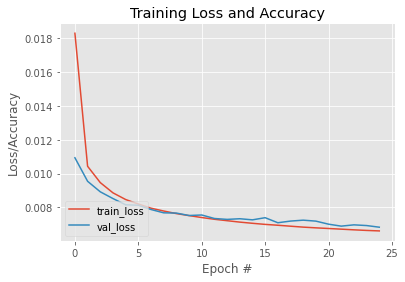

In [14]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

[INFO] making predictions...


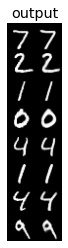

In [15]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
outputs = None

# loop over our number of output samples
for i in range(0, args["samples"]):
	# grab the original image and reconstructed image
	original = (testX[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
 
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# save the outputs image to disk and display it
cv2.imwrite(args["output"], outputs)
plt_imshow("output", outputs)

# Denoising autoencoders with Keras, TensorFlow, and Deep Learning

The term “noise” here could be:

* Produced by a faulty or poor quality image sensor
* Random variations in brightness or color
* Quantization noise
* Artifacts due to JPEG compression
* Image perturbations produced by an image scanner or threshold post-processing
* Poor paper quality (crinkles and folds) when trying to perform OCR

## What are denoising autoencoders, and why would we use them?
<image src="images/keras_denoising_autoencoder_overview.png">

Instead, the denoising autoencoder procedure was invented to help:

* The hidden layers of the autoencoder learn more robust filters
* Reduce the risk of overfitting in the autoencoder
* Prevent the autoencoder from learning a simple identify function

From an image processing standpoint, we can train an autoencoder to perform automatic image pre-processing for us.

A great example would be pre-processing an image to improve the accuracy of an optical character recognition (OCR) algorithm.

### Implementing the denoising autoencoder training script

In [16]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-s", "--samples", type=int, default=8,
#	help="# number of samples to visualize when decoding")
#ap.add_argument("-o", "--output", type=str, default="output.png",
#	help="path to output visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"samples": 8,
	"output": "output.png",
	"plot": "plot.png"
}

In [17]:
# initialize the number of epochs to train for and batch size
EPOCHS = 25
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, _), (testX, _)) = mnist.load_data()

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
trainX = np.expand_dims(trainX, axis=-1)
testX = np.expand_dims(testX, axis=-1)
trainX = trainX.astype("float32") / 255.0
testX = testX.astype("float32") / 255.0

[INFO] loading MNIST dataset...


To add random noise to the MNIST digits, we use NumPy’s random normal distribution centered at 0.5 with a standard deviation of 0.5 (Lines 41-44).

In [18]:
# sample noise from a random normal distribution centered at 0.5 (since
# our images lie in the range [0, 1]) and a standard deviation of 0.5
trainNoise = np.random.normal(loc=0.5, scale=0.5, size=trainX.shape)
testNoise = np.random.normal(loc=0.5, scale=0.5, size=testX.shape)
trainXNoisy = np.clip(trainX + trainNoise, 0, 1)
testXNoisy = np.clip(testX + testNoise, 0, 1)

In [19]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=1e-3)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainXNoisy, trainX,
	validation_data=(testXNoisy, testX),
	epochs=EPOCHS,
	batch_size=BS)

[INFO] building autoencoder...
Epoch 1/25
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0436 - val_loss: 0.0196
Epoch 2/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0192 - val_loss: 0.0178
Epoch 3/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0179 - val_loss: 0.0176
Epoch 4/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0172 - val_loss: 0.0170
Epoch 5/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0168 - val_loss: 0.0165
Epoch 6/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0164 - val_loss: 0.0166
Epoch 7/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0162 - val_loss: 0.0168
Epoch 8/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0160 - val_loss: 0.0169
Epoch 9/25
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0158 - val_loss: 0.0168
Epoch 10/25
1875/1875 [============================

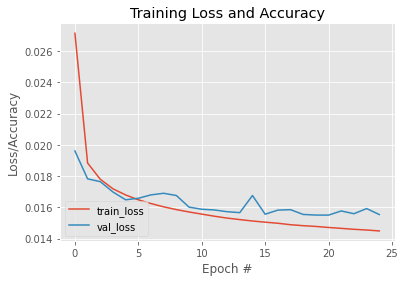

In [20]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

[INFO] making predictions...


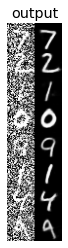

In [21]:
# use the convolutional autoencoder to make predictions on the
# testing images, then initialize our list of output images
print("[INFO] making predictions...")
decoded = autoencoder.predict(testXNoisy)
outputs = None

# loop over our number of output samples
for i in range(0, args["samples"]):
	# grab the original image and reconstructed image
	original = (testXNoisy[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")
 
	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])
 
	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# save the outputs image to disk and display it
cv2.imwrite(args["output"], outputs)
plt_imshow("output", outputs)

# Anomaly detection with Keras, TensorFlow, and Deep Learning

## What is anomaly detection?

<image src="images/intro_anomaly_detection_definition.png">

Examples of anomalies include:

* Large dips and spikes in the stock market due to world events
* Defective items in a factory/on a conveyor belt
* Contaminated samples in a lab

Depending on your exact use case and application, anomalies only typically occur 0.001-1% of the time — that’s an incredibly small fraction of the time.

To detect anomalies, machine learning researchers have created algorithms such as Isolation Forests, One-class SVMs, Elliptic Envelopes, and Local Outlier Factor to help detect such events; however, all of these methods are rooted in traditional machine learning.

However, what makes autoencoders so special from an anomaly detection perspective is the reconstruction loss. When we train an autoencoder, we typically measure the mean-squared-error (MSE) between:

1. The input image
2. The reconstructed image from the autoencoder

The lower the loss, the better a job the autoencoder is doing at reconstructing the image.

Let’s now suppose that we trained an autoencoder on the entirety of the MNIST dataset:

<image src="images/autoencoder_anomaly_detection_digit.png">

Let’s now suppose we presented our autoencoder with a photo of an elephant and asked it to reconstruct it:

<image src="images/autoencoder_anomaly_detection_elephant.png">

Since the autoencoder has never seen an elephant before, and more to the point, was never trained to reconstruct an elephant, our MSE will be very high.

If the MSE of the reconstruction is high, then we likely have an outlier.

### Implementing the anomaly detection training script

Our build_supervised_dataset function accepts a labeled dataset (i.e., for supervised learning) and turns it into an unlabeled dataset (i.e., for unsupervised learning).

The function accepts a set of input data and labels, including valid label and anomaly label.

Given that our validLabel=1 by default, only MNIST numeral ones are selected; however, we’ll also contaminate our dataset with a set of numeral three images (validLabel=3).

In [22]:
def build_unsupervised_dataset(data, labels, validLabel=1,
	anomalyLabel=3, contam=0.01, seed=42):
	# grab all indexes of the supplied class label that are *truly*
	# that particular label, then grab the indexes of the image
	# labels that will serve as our "anomalies"
	validIdxs = np.where(labels == validLabel)[0]
	anomalyIdxs = np.where(labels == anomalyLabel)[0]

	# randomly shuffle both sets of indexes
	random.shuffle(validIdxs)
	random.shuffle(anomalyIdxs)

	# compute the total number of anomaly data points to select
	i = int(len(validIdxs) * contam)
	anomalyIdxs = anomalyIdxs[:i]

	# use NumPy array indexing to extract both the valid images and
	# "anomlay" images
	validImages = data[validIdxs]
	anomalyImages = data[anomalyIdxs]

	# stack the valid images and anomaly images together to form a
	# single data matrix and then shuffle the rows
	images = np.vstack([validImages, anomalyImages])
	np.random.seed(seed)
	np.random.shuffle(images)

	# return the set of images
	return images

In [23]:
def visualize_predictions(decoded, gt, samples=10):
	# initialize our list of output images
	outputs = None

	# loop over our number of output samples
	for i in range(0, samples):
		# grab the original image and reconstructed image
		original = (gt[i] * 255).astype("uint8")
		recon = (decoded[i] * 255).astype("uint8")

		# stack the original and reconstructed image side-by-side
		output = np.hstack([original, recon])

		# if the outputs array is empty, initialize it as the current
		# side-by-side image display
		if outputs is None:
			outputs = output

		# otherwise, vertically stack the outputs
		else:
			outputs = np.vstack([outputs, output])

	# return the output images
	return outputs

In [24]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#	help="path to output dataset file")
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to output trained autoencoder")
#ap.add_argument("-v", "--vis", type=str, default="recon_vis.png",
#	help="path to output reconstruction visualization file")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output plot file")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"vis": "output/Anomaly_recon_vis.png",
	"plot": "output/Anomaly_plot.png"	
}

In [25]:
# initialize the number of epochs to train for, initial learning rate,
# and batch size
EPOCHS = 20
INIT_LR = 1e-3
BS = 32

# load the MNIST dataset
print("[INFO] loading MNIST dataset...")
((trainX, trainY), (testX, testY)) = mnist.load_data()

# build our unsupervised dataset of images with a small amount of
# contamination (i.e., anomalies) added into it
print("[INFO] creating unsupervised dataset...")
images = build_unsupervised_dataset(trainX, trainY, validLabel=1,
	anomalyLabel=3, contam=0.01)

# add a channel dimension to every image in the dataset, then scale
# the pixel intensities to the range [0, 1]
images = np.expand_dims(images, axis=-1)
images = images.astype("float32") / 255.0

# construct the training and testing split
(trainX, testX) = train_test_split(images, test_size=0.2,
	random_state=42)

[INFO] loading MNIST dataset...
[INFO] creating unsupervised dataset...


[INFO] building autoencoder...
Epoch 1/20
171/171 [==============================] - 2s 6ms/step - loss: 0.0816 - val_loss: 0.0440
Epoch 2/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0081 - val_loss: 0.0320
Epoch 3/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0039 - val_loss: 0.0106
Epoch 4/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0033 - val_loss: 0.0030
Epoch 5/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0031 - val_loss: 0.0025
Epoch 6/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 7/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0025 - val_loss: 0.0027
Epoch 8/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0023 - val_loss: 0.0027
Epoch 9/20
171/171 [==============================] - 1s 5ms/step - loss: 0.0022 - val_loss: 0.0023
Epoch 10/20
171/171 [==============================] - 1s 5ms/step - 

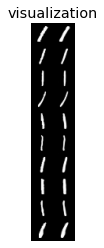

In [26]:
# construct our convolutional autoencoder
print("[INFO] building autoencoder...")
(encoder, decoder, autoencoder) = ConvAutoencoder.build(28, 28, 1)
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
autoencoder.compile(loss="mse", optimizer=opt)

# train the convolutional autoencoder
H = autoencoder.fit(
	trainX, trainX,
	validation_data=(testX, testX),
	epochs=EPOCHS,
	batch_size=BS)

# use the convolutional autoencoder to make predictions on the
# testing images, construct the visualization, and then save it
# to disk
print("[INFO] making predictions...")
decoded = autoencoder.predict(testX)
vis = visualize_predictions(decoded, testX)
cv2.imwrite(args["vis"], vis)
plt_imshow("visualization", vis)

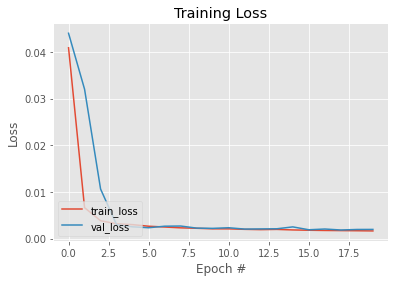

[INFO] saving image data...
[INFO] saving autoencoder...


In [27]:
# construct a plot that plots and saves the training history
N = np.arange(0, EPOCHS)
plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig(args["plot"])
plt.show()

# serialize the image data to disk
print("[INFO] saving image data...")
f = open(args["dataset"], "wb")
f.write(pickle.dumps(images))
f.close()

# serialize the autoencoder model to disk
print("[INFO] saving autoencoder...")
autoencoder.save(args["model"], save_format="h5")

### Implementing our script to find anomalies/outliers using the autoencoder

In [28]:
# construct the argument parse and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", type=str, required=True,
#	help="path to input image dataset file")
#ap.add_argument("-m", "--model", type=str, required=True,
#	help="path to trained autoencoder")
#ap.add_argument("-q", "--quantile", type=float, default=0.999,
#	help="q-th quantile used to identify outliers")
#args = vars(ap.parse_args())

# since we are using Jupyter Notebooks we can replace our argument
# parsing code with *hard coded* arguments and values
args = {
	"dataset": "output/images.pickle",
	"model": "output/autoencoder.model",
	"quantile": 0.999	
}

In [29]:
# load the model and image data from disk
print("[INFO] loading autoencoder and image data...")
autoencoder = load_model(args["model"])
images = pickle.loads(open(args["dataset"], "rb").read())

# make predictions on our image data and initialize our list of
# reconstruction errors
decoded = autoencoder.predict(images)
errors = []

# loop over all original images and their corresponding
# reconstructions
for (image, recon) in zip(images, decoded):
	# compute the mean squared error between the ground-truth image
	# and the reconstructed image, then add it to our list of errors
	mse = np.mean((image - recon) ** 2)
	errors.append(mse)

[INFO] loading autoencoder and image data...


In [30]:
# compute the q-th quantile of the errors which serves as our
# threshold to identify anomalies -- any data point that our model
# reconstructed with > threshold error will be marked as an outlier
thresh = np.quantile(errors, args["quantile"])
idxs = np.where(np.array(errors) >= thresh)[0]
print("[INFO] mse threshold: {}".format(thresh))
print("[INFO] {} outliers found".format(len(idxs)))

[INFO] mse threshold: 0.024292546495795254
[INFO] 7 outliers found


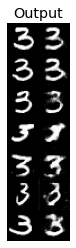

In [31]:
# initialize the outputs array
outputs = None

# loop over the indexes of images with a high mean squared error term
for i in idxs:
	# grab the original image and reconstructed image
	original = (images[i] * 255).astype("uint8")
	recon = (decoded[i] * 255).astype("uint8")

	# stack the original and reconstructed image side-by-side
	output = np.hstack([original, recon])

	# if the outputs array is empty, initialize it as the current
	# side-by-side image display
	if outputs is None:
		outputs = output

	# otherwise, vertically stack the outputs
	else:
		outputs = np.vstack([outputs, output])

# show the output visualization
plt_imshow("Output", outputs)